# This notebook contain solution for categorical classification problem of EGG biomedical artifacts 

<img src="img/1.png" alt="Drawing"align="center"/>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import time
import os

/Users/michalgorski/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%cd "/Volumes/Pamiec128/Studia/Magisterka/Dyplom/Keras"

/Volumes/Pamiec128/Studia/Magisterka/Dyplom/Keras


### 1. Remove highest value from "No Signal State" 

In [3]:
tic = time.time()
start = time.time()

no_signal = pd.read_csv("no_signal.csv")
no_signal = no_signal.iloc[: ,2:16]
no_signal_max = 0


features_max = no_signal.max()
no_signal_max = features_max.max()
print("Max Value: " , no_signal_max)
    
toc = time.time()
print("Exec time",str((toc-tic)) + "s")



Max Value:  4310.25634765625
Exec time 0.1494588851928711s


### 2. Get EEG Artifacts data in 1 Array with outputs

In [4]:
eegCSV = ["eyesClosed2.csv","eyebrows2.csv","smile2.csv","teeth2.csv"]
dataArray= []
counter = 0

tic = time.time()

for j in range(len(eegCSV)): #csv
    current = pd.read_csv(eegCSV[j]) 
    current = current.iloc[: ,2:16]
    current["Output"] = 0  # ADD output colum
    rowMax = (current.max(axis=1))
    for i in rowMax:
        if i > no_signal_max:
            current.iloc[counter,-1] = j+1
        counter = counter + 1 
        #print(counter) 
    dataArray.append(current)      
    counter = 0
    
eegToLearn = pd.concat(dataArray,ignore_index=True)
eegToLearn = eegToLearn[eegToLearn.Output != 0] 
        
toc = time.time()

print("Exec time",str((toc-tic)) + "s")

        



Exec time 3.9936368465423584s


### 3. Plot Data

In [5]:
%matplotlib inline

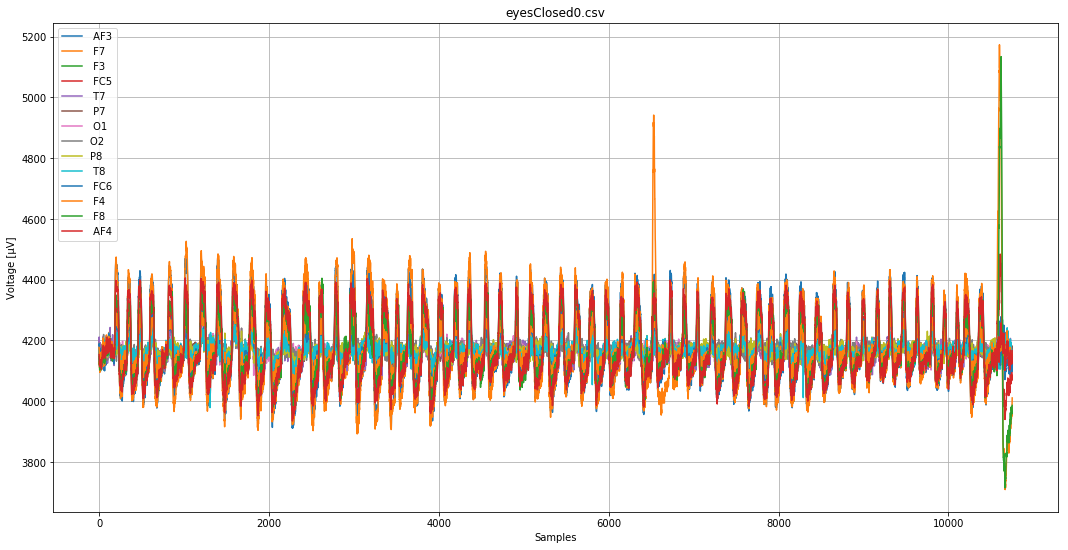

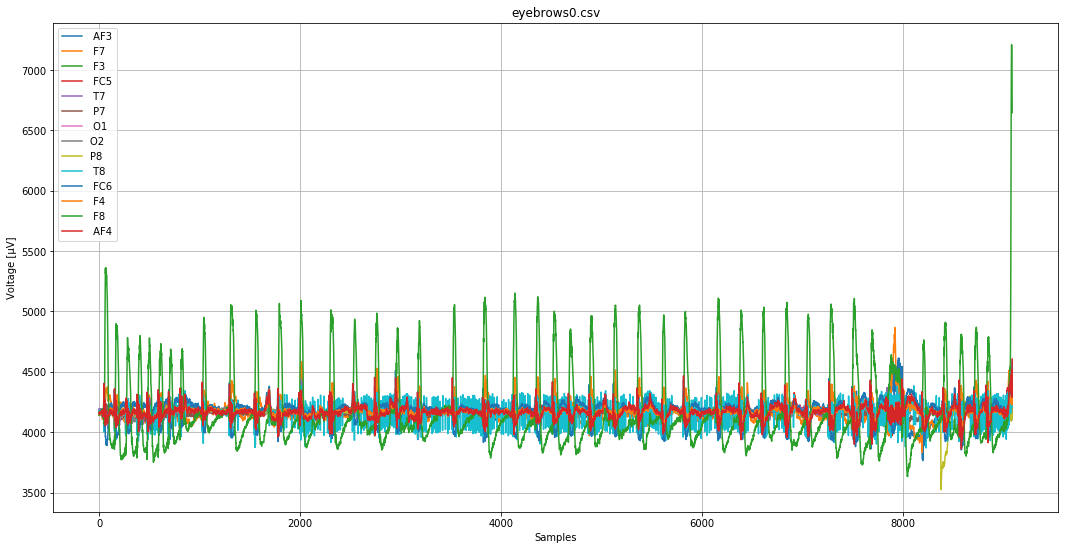

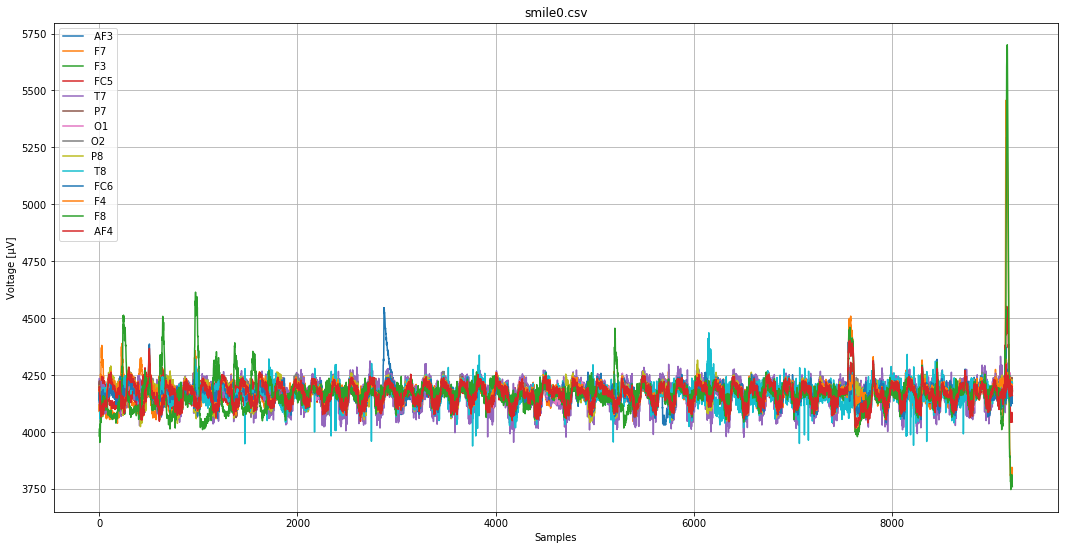

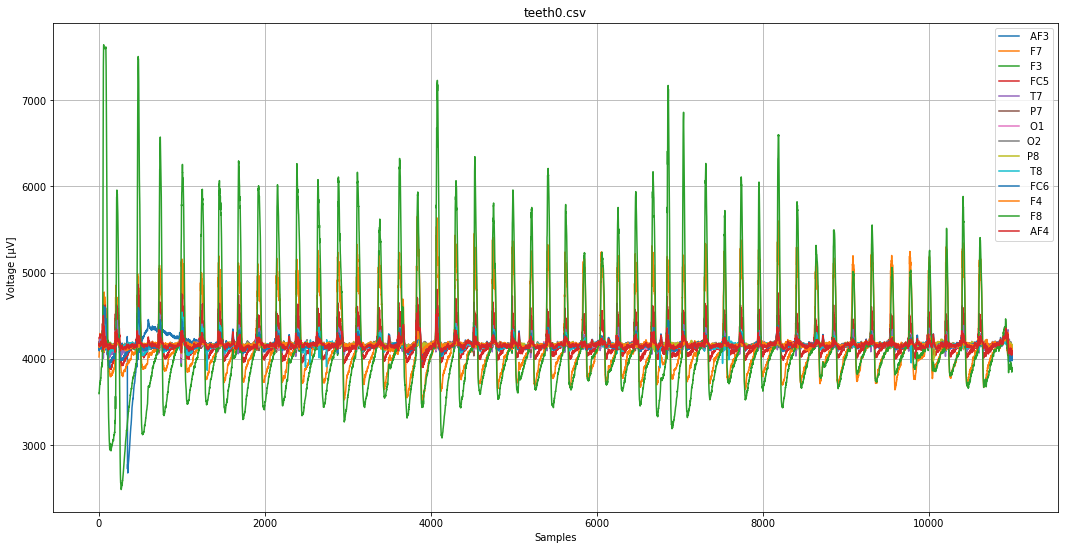

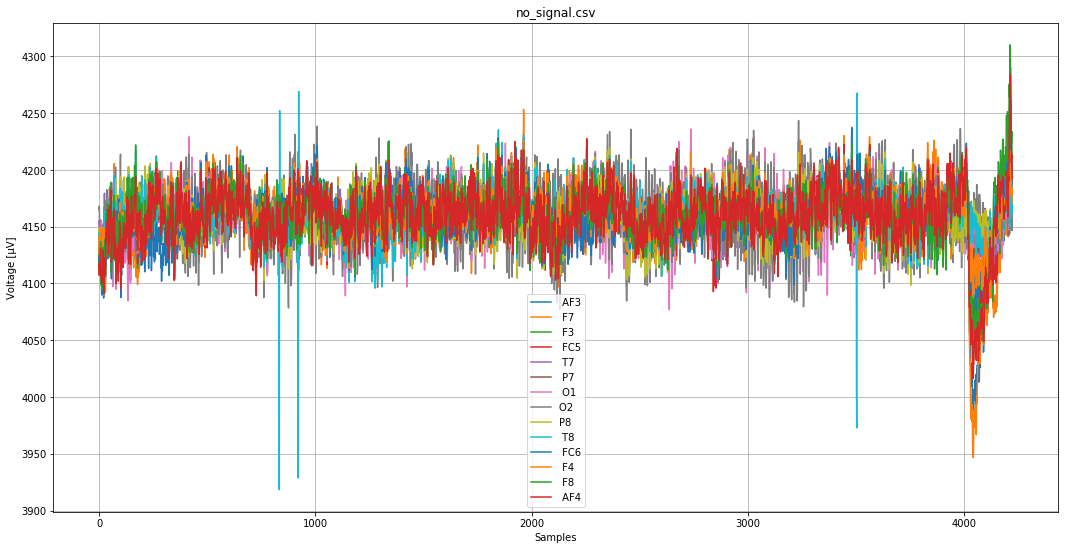

In [6]:
"""
Created on Mon Mar  5 13:08:26 2018
@author: michalgorski
"""
import matplotlib.pyplot as plt
import pandas as pd

tic = time.time()



eegCSV = ["eyesClosed0.csv","eyebrows0.csv","smile0.csv","teeth0.csv","no_signal.csv"]
nameArray = list(eegToLearn.columns.values[0:14])
#saveAS = ["eyesClosed.png","leftEye.png","rightEye.png","eyebrows.png","smile.png"]




def plotConfigure():
    plt.figure(j,figsize=(18,9))
    plt.xlabel("Samples")
    plt.ylabel('Voltage [μV]')
    plt.grid(axis='both')
    

#Plot data

for j in range(len(eegCSV)):
    
    current_dataset = pd.read_csv(eegCSV[j])
    dataset = current_dataset.iloc[: ,2:16].values
    plotConfigure()
    counter = 0 

    while counter < len(nameArray) : 
         
        plt.plot(dataset[:,counter],label = nameArray[counter])
      
        plt.title(eegCSV[j])
        plt.legend()
        counter = counter + 1 
        

plt.show()
toc = time.time()


### 4. Data Preprocessing

In [7]:

tic = time.time()

#Split to features and labels
X = eegToLearn.iloc[: ,0:14].values
Y = eegToLearn.iloc[: ,-1].values

eegTouple = (X,Y)
   
#Encoding categorical data 
encoder = LabelEncoder()
encoder.fit(Y).transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
Y = np_utils.to_categorical(encoder.transform(Y))


#Splitting dataSet into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 0)

#Feature Scaling , in this case not important but algorithm work faster
#Check out Standarize vs Normalize

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

toc = time.time()
print("Exec time",str((toc-tic)) + "s")

Exec time 0.06229805946350098s


### 5. Use Machine learning algorithms

In [8]:

import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn import tree
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import graphviz 

eeg_feature_names = list(eegToLearn.iloc[: ,0:14])
eeg_class_names = ["1","2","3","4","5","6"]
eeg_predictions = []


accAll = {}
Y_test = np.argmax(Y_test,axis = 1)
Y_train = np.argmax(Y_train,axis = 1)


# =================================================================================================
#                                   SVM ONE AGAINST ONE APPROACH
# =================================================================================================

svc = svm.SVC()
svc.fit(X_train, Y_train)
svc_pred = svc.predict(X_test)
eeg_predictions.append(svc_pred)
accAll["SVM 1vs1"]=(accuracy_score(Y_test,svc_pred))*100
#report_svmOne =((Y_test,svc_pred))
   

# =================================================================================================
#                                  SVM   ONE AGAINST THE REST
# =================================================================================================
lsvc = LinearSVC()
lsvc.fit(X_train, Y_train)
lsvc_pred = lsvc.predict(X_test)
eeg_predictions.append(lsvc_pred)
accAll["SVM 1vsAll"]=( accuracy_score(Y_test,lsvc_pred ))*100
#report_lsvc  =(classification_report(Y_test,lsvc_pred)


# =================================================================================================
#                                           KNN
# =================================================================================================

KNN = KNeighborsClassifier(n_neighbors = 12)
KNN.fit(X_train, Y_train)
KNN_pred = KNN.predict(X_test)
eeg_predictions.append(KNN_pred)
accAll["KNN"]=(accuracy_score(Y_test,KNN_pred))*100
#report_knn  =(classification_report(Y_test,KNN_pred))

# =================================================================================================
#                                       Naive Bayes
# =================================================================================================

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
gnb_pred = gnb.predict(X_test)
eeg_predictions.append(gnb_pred)

accAll["Naive Bayes"]=(accuracy_score(Y_test,gnb_pred))*100
#report_Bayes  =(classification_report(Y_test,gnb_pred))


# =================================================================================================
#                                 Linear Discriminant Analysis
# =================================================================================================

lda = LDA()
lda.fit(X_train, Y_train)
lda_pred = lda.predict(X_test)
eeg_predictions.append(gnb_pred)
accAll["LDA"]=(accuracy_score(Y_test,lda_pred))*100
#report_Bayes  =(classification_report(Y_test,gnb_pred))


In [9]:
print ("Machine Learning Models:\n")
    
print("1. SVM 1vs1 :", accAll["SVM 1vs1"])
print("2. SVM 1vsAll", accAll["SVM 1vsAll"])
print("3. KNN :", accAll["KNN"])
print("4. Naive Bayes :", accAll["Naive Bayes"])
print("5. LDA :", accAll["LDA"])


Machine Learning Models:

1. SVM 1vs1 : 94.59234608985025
2. SVM 1vsAll 73.12811980033278
3. KNN : 97.67054908485858
4. Naive Bayes : 47.587354409317804
5. LDA : 71.04825291181365


### 6.Lets look at KNearest-Neigbors

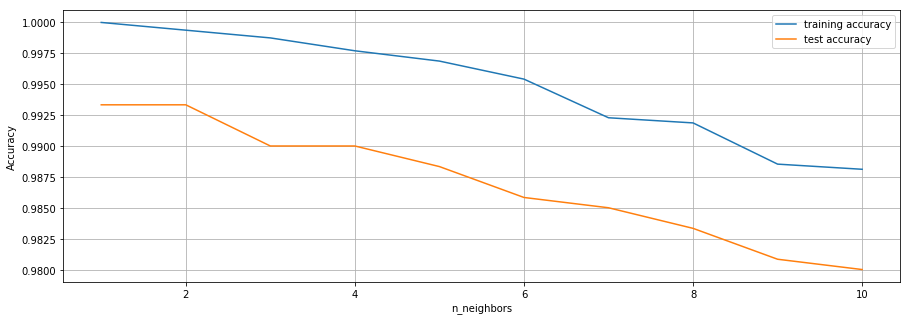

In [10]:
training_accuracy = []
test_accuracy = []

# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
  
for n_neighbors in neighbors_settings:
    
    KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    KNN.fit(X_train, Y_train)
    training_accuracy.append(KNN.score(X_train, Y_train))
    test_accuracy.append(KNN.score(X_test, Y_test))

plt.figure(figsize=(15,5))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.grid()
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [11]:
KNN = KNeighborsClassifier(n_neighbors = 1)
KNN.fit(X_train, Y_train)
KNN_pred = KNN.predict(X_test)
eeg_predictions.append(KNN_pred)
accAll["KNN"]=(accuracy_score(Y_test,KNN_pred))*100
report_knn  =(classification_report(Y_test,KNN_pred))

In [12]:
print("Test accuracy : ", accAll["KNN"], "\n")
print(report_knn)

Test accuracy :  99.33444259567388 

             precision    recall  f1-score   support

          0       1.00      0.96      0.98        46
          1       1.00      0.99      0.99       420
          2       0.99      1.00      0.99       438
          3       1.00      1.00      1.00       298

avg / total       0.99      0.99      0.99      1202



### 7. Create ANN Classification Model

In [13]:
# Go to preprocess part

X = eegToLearn.iloc[: ,0:14].values
Y = eegToLearn.iloc[: ,-1].values

eegTouple = (X,Y)
   
#Encoding categorical data 
encoder = LabelEncoder()
encoder.fit(Y).transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
Y = np_utils.to_categorical(encoder.transform(Y))


#Splitting dataSet into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 0)

#Feature Scaling , in this case not important but algorithm work faster
#Check out Standarize vs Normalize

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

toc = time.time()
print("Exec time",str((toc-tic)) + "s")

Exec time 4.779860019683838s


In [14]:
tic = time.time()
#1.Import Libraries 
import keras 
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
import numpy as np 

# 2.Set Callbacks
from keras.callbacks import Callback, EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose = 0, mode='auto')]

# 3.Set Params
batch = 20
epoch = 500

# 4.Define & Train Model
model = Sequential()
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
history = model.fit(X_train, Y_train,batch_size = batch , epochs = epoch,validation_split = 0.3,callbacks = callbacks)
#os.system('say "Zrobione szefie"')
toc = time.time()
print("Exec time",str((toc-tic)) + "s")

Train on 3362 samples, validate on 1442 samples
Epoch 1/500
3362/3362 [==============================] - 1s 280us/step - loss: 1.2892 - acc: 0.3888 - val_loss: 1.1740 - val_acc: 0.4265
Epoch 2/500
3362/3362 [==============================] - 0s 132us/step - loss: 1.1391 - acc: 0.4325 - val_loss: 1.1332 - val_acc: 0.4417
Epoch 3/500
3362/3362 [==============================] - 1s 197us/step - loss: 1.1086 - acc: 0.4310 - val_loss: 1.1141 - val_acc: 0.4397
Epoch 4/500
3362/3362 [==============================] - 0s 139us/step - loss: 1.0812 - acc: 0.4414 - val_loss: 1.0767 - val_acc: 0.4501
Epoch 5/500
3362/3362 [==============================] - 1s 169us/step - loss: 1.0186 - acc: 0.4679 - val_loss: 0.9899 - val_acc: 0.5062
Epoch 6/500
3362/3362 [==============================] - 1s 197us/step - loss: 0.9397 - acc: 0.5057 - val_loss: 0.9277 - val_acc: 0.5326
Epoch 7/500
3362/3362 [==============================] - 1s 184us/step - loss: 0.8854 - acc: 0.5708 - val_loss: 0.8837 - val_acc: 

3362/3362 [==============================] - 0s 106us/step - loss: 0.3301 - acc: 0.9114 - val_loss: 0.3723 - val_acc: 0.8974
Epoch 61/500
3362/3362 [==============================] - 0s 135us/step - loss: 0.3255 - acc: 0.9137 - val_loss: 0.3728 - val_acc: 0.8918
Epoch 62/500
3362/3362 [==============================] - 0s 119us/step - loss: 0.3242 - acc: 0.9149 - val_loss: 0.3685 - val_acc: 0.9001
Epoch 63/500
3362/3362 [==============================] - 0s 113us/step - loss: 0.3219 - acc: 0.9152 - val_loss: 0.3674 - val_acc: 0.8932
Epoch 64/500
3362/3362 [==============================] - 0s 113us/step - loss: 0.3187 - acc: 0.9203 - val_loss: 0.3618 - val_acc: 0.8981
Epoch 65/500
3362/3362 [==============================] - 0s 108us/step - loss: 0.3206 - acc: 0.9120 - val_loss: 0.3621 - val_acc: 0.9022
Epoch 66/500
3362/3362 [==============================] - 0s 110us/step - loss: 0.3140 - acc: 0.9194 - val_loss: 0.3570 - val_acc: 0.9036
Epoch 67/500
3362/3362 [=======================

3362/3362 [==============================] - 0s 143us/step - loss: 0.1050 - acc: 0.9765 - val_loss: 0.1348 - val_acc: 0.9653
Epoch 179/500
3362/3362 [==============================] - 0s 130us/step - loss: 0.1033 - acc: 0.9768 - val_loss: 0.1380 - val_acc: 0.9632
Epoch 180/500
3362/3362 [==============================] - 0s 118us/step - loss: 0.1030 - acc: 0.9756 - val_loss: 0.1388 - val_acc: 0.9667
Epoch 181/500
3362/3362 [==============================] - 0s 115us/step - loss: 0.1020 - acc: 0.9774 - val_loss: 0.1453 - val_acc: 0.9632
Epoch 182/500
3362/3362 [==============================] - 0s 125us/step - loss: 0.1029 - acc: 0.9765 - val_loss: 0.1336 - val_acc: 0.9667
Epoch 183/500
3362/3362 [==============================] - 0s 119us/step - loss: 0.0996 - acc: 0.9783 - val_loss: 0.1305 - val_acc: 0.9695
Epoch 184/500
3362/3362 [==============================] - 0s 113us/step - loss: 0.0973 - acc: 0.9789 - val_loss: 0.1301 - val_acc: 0.9709
Epoch 185/500
3362/3362 [================

In [15]:
print("Model training metrics:\n")
print("1. acc : ",history.history["acc"][-1])
print("2. acc_val : ",history.history["val_acc"][-1])
print("3. loss : ",history.history["loss"][-1])
print("4. loss_val : ",history.history["val_loss"][-1])

Model training metrics:

1. acc :  0.9875074330715109
2. acc_val :  0.9764216318209856
3. loss :  0.06531012625362034
4. loss_val :  0.10522353983433833


### Test ANN model

In [16]:
test_loss , test_accuracy =  model.evaluate(X_test,Y_test)

1202/1202 [==============================] - 0s 51us/step


In [17]:
print("Artificial Neural Network\n")
print("Test accuracy :",str(test_accuracy))
print("Test loss :",str(test_loss))

Artificial Neural Network

Test accuracy : 0.9725457566748443
Test loss : 0.10289491626268218


In [19]:
model_pred = model.predict(X_test)
model_pred = np.argmax(model_pred,axis = 1)
eeg_predictions.append(model_pred)
Y_test = np.argmax(Y_test,axis = 1)
report_model = (classification_report(Y_test,model_pred))
print(report_model)

             precision    recall  f1-score   support

          0       0.98      0.91      0.94        46
          1       0.96      0.98      0.97       420
          2       0.98      0.96      0.97       438
          3       0.98      0.99      0.98       298

avg / total       0.97      0.97      0.97      1202



### 8. Plot learning Metrics

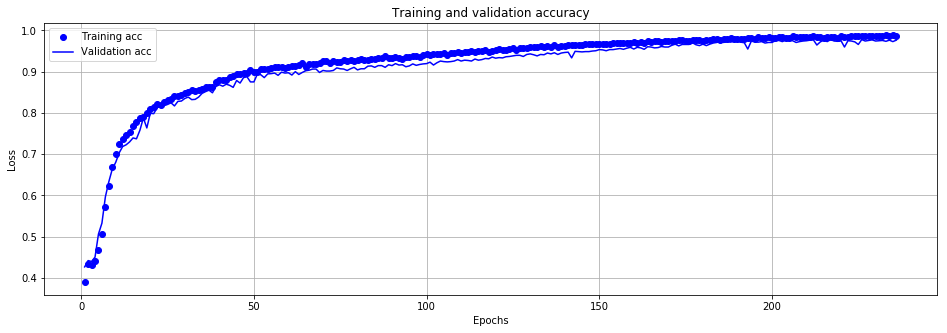

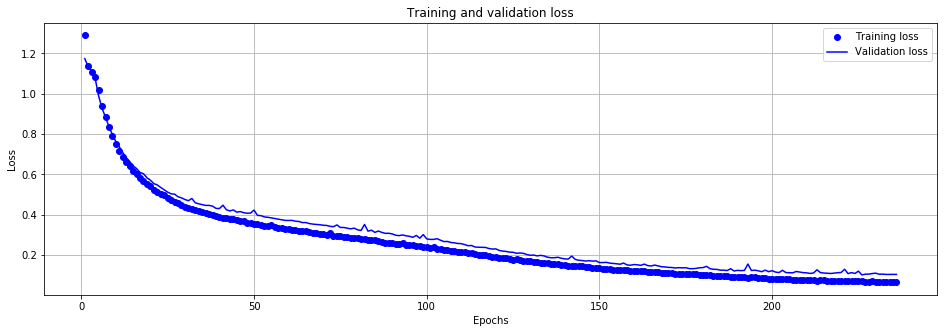

Exec time 0.5274009704589844s


In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May  5 17:27:50 2018

@author: michalgorski
"""

import matplotlib.pyplot as plt
tic = time.time()
plt.figure(figsize = (16,5))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.clf() 
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis = "both")
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize = (16,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis='both')
plt.show()
toc = time.time()
print("Exec time",str((toc-tic)) + "s")

### 9. Plot ACC & Loss Validation plot

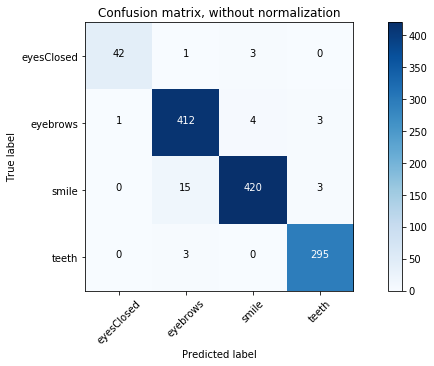

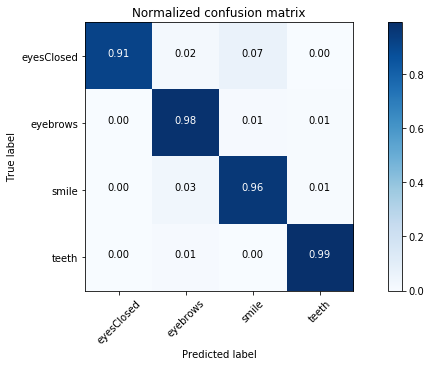

Exec time 0.6822640895843506s


In [21]:
# Confusion Matrix code source : 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""
Created on Thu Apr 26 11:32:28 2018

@author: michalgorski
"""

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

tic = time.time()
class_names = ["eyesClosed","eyebrows","smile","teeth"]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# Predicting the Test set results
Y_pred = model.predict(X_test) 
y_pred = np.argmax(Y_pred,axis = 1)
y_pred = model.predict_classes(X_test)   
cnf_matrix = confusion_matrix(Y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure(6,figsize = (10,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(7,figsize = (10,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
toc = time.time()
print("Exec time",str((toc-tic)) + "s")


### 9.Final results

In [32]:
print("ANN tetst accuracy", str(test_accuracy))
print("KNN test accuracy : ", accAll["KNN"], "\n")

ANN tetst accuracy 0.9725457566748443
KNN test accuracy :  99.33444259567388 

